In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# dataset verification and renaming

In [ ]:
from pathlib import Path
import os

def rename_split(images_dir, labels_dir):
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    images = sorted([p for p in images_dir.iterdir()
                     if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])

    for idx, img_path in enumerate(images, start=1):
        new_stem = f"img_{idx:04d}"  # img_0001, img_0002, ...
        new_img_path = img_path.with_name(new_stem + img_path.suffix)

        old_label_path = labels_dir / (img_path.stem + ".txt")
        new_label_path = labels_dir / (new_stem + ".txt")

        if old_label_path.exists():
            img_path.rename(new_img_path)
            old_label_path.rename(new_label_path)
        else:
            print(f"WARNING: No label for {img_path.name}")

# train
rename_split(
    "/content/drive/MyDrive/brain_tumor_det/BR35H roboflow/images/train",
    "/content/drive/MyDrive/brain_tumor_det/BR35H roboflow/labels/train"
)

# val
rename_split(
    "/content/drive/MyDrive/brain_tumor_det/BR35H roboflow/images/val",
    "/content/drive/MyDrive/brain_tumor_det/BR35H roboflow/labels/val"
)

# test
rename_split(
    "/content/drive/MyDrive/brain_tumor_det/BR35H roboflow/images/test",
    "/content/drive/MyDrive/brain_tumor_det/BR35H roboflow/labels/test"
)

#train
rename_split(
    "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset/images/train",
    "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset/labels/train"
)

# val
rename_split(
    "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset/images/val",
    "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset/labels/val"
)

# test
rename_split(
    "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset/images/test",
    "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset/labels/test"
)


In [ ]:
import os
from pathlib import Path

def verify_dataset(dataset_path):
    """
    Verify dataset structure and annotations
    """
    splits = ['train', 'val', 'test']

    for split in splits:
        img_dir = Path(dataset_path) / 'images' / split
        label_dir = Path(dataset_path) / 'labels' / split

        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
        labels = list(label_dir.glob('*.txt'))

        print(f"\n{split.upper()} SET:")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")

        # Check for missing annotations
        missing_labels = []
        for img in images:
            label_file = label_dir / f"{img.stem}.txt"
            if not label_file.exists():
                missing_labels.append(img.name)

        if missing_labels:
            print(f"  WARNING: {len(missing_labels)} images without labels")
            print(f"  First few: {missing_labels[:5]}")
        else:
            print(f"  ✓ All images have corresponding labels")

# Usage
verify_dataset('/content/drive/MyDrive/brain_tumor_det/BR35H_roboflow_boxes')
verify_dataset('/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset')



TRAIN SET:
  Images: 561
  Labels: 561
  ✓ All images have corresponding labels

VAL SET:
  Images: 160
  Labels: 160
  ✓ All images have corresponding labels

TEST SET:
  Images: 80
  Labels: 80
  ✓ All images have corresponding labels

TRAIN SET:
  Images: 1695
  Labels: 1695
  ✓ All images have corresponding labels

VAL SET:
  Images: 502
  Labels: 502
  ✓ All images have corresponding labels

TEST SET:
  Images: 246
  Labels: 246
  ✓ All images have corresponding labels


#polygon to box transformation

In [ ]:
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/BR35H roboflow")  # CHANGE to your current dataset root
OUT_ROOT = Path("/content/drive/MyDrive/BR35H_roboflow_boxes")  # new cleaned copy

splits = ["train", "val", "test"]

def convert_poly_to_box(src_root, dst_root, split):
    img_src = src_root / "images" / split
    lbl_src = src_root / "labels" / split

    img_dst = dst_root / "images" / split
    lbl_dst = dst_root / "labels" / split
    img_dst.mkdir(parents=True, exist_ok=True)
    lbl_dst.mkdir(parents=True, exist_ok=True)

    # copy images
    import shutil
    for img_path in img_src.glob("*.*"):
        shutil.copy2(img_path, img_dst / img_path.name)

    # convert labels
    for txt_path in lbl_src.glob("*.txt"):
        lines_out = []
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls = parts[0]
                coords = list(map(float, parts[1:]))

                xs = coords[0::2]
                ys = coords[1::2]

                x_min, x_max = min(xs), max(xs)
                y_min, y_max = min(ys), max(ys)

                x_c = (x_min + x_max) / 2.0
                y_c = (y_min + y_max) / 2.0
                w   = (x_max - x_min)
                h   = (y_max - y_min)

                lines_out.append(f"{cls} {x_c} {y_c} {w} {h}\n")

        with open(lbl_dst / txt_path.name, "w") as f:
            f.writelines(lines_out)

for s in splits:
    convert_poly_to_box(ROOT, OUT_ROOT, s)

print("Done. Use", OUT_ROOT, "for YOLOv8 training.")


Done. Use /content/drive/MyDrive/BR35H_roboflow_boxes for YOLOv8 training.


#visualizer

In [ ]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/BR35H_roboflow_boxes")  # cleaned dataset

CLASS_NAME = "tumor"

def show_image_with_labels(img_path, label_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x_c, y_c, bw, bh = map(float, parts)
                x_c, y_c, bw, bh = x_c * w, y_c * h, bw * w, bh * h

                x1 = int(x_c - bw / 2)
                y1 = int(y_c - bh / 2)
                x2 = int(x_c + bw / 2)
                y2 = int(y_c + bh / 2)

                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, CLASS_NAME, (x1, max(0, y1 - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.name)
    plt.show()


In [ ]:
def visualize_split(root, split="train", n_samples=5):
    img_dir = root / "images" / split
    lbl_dir = root / "labels" / split

    image_paths = sorted([p for p in img_dir.iterdir()
                          if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
    image_paths = image_paths[:n_samples]

    print(f"Showing {len(image_paths)} images from {split}")
    for img_path in image_paths:
        label_path = lbl_dir / (img_path.stem + ".txt")
        show_image_with_labels(img_path, label_path)

for sp in ["train", "val", "test"]:
    visualize_split(ROOT, split=sp, n_samples=10)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def show_image_with_labels(img_path, label_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    box_color = (255, 0, 0)      # red (B, G, R)
    text_color = (255, 255, 255) # white

    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                # Expect at least 5 values: cls x_c y_c w h
                if len(parts) < 5:
                    continue

                # Read only first 5 in case there are extras (e.g. conf)
                cls, x_c, y_c, bw, bh = map(float, parts[:5])
                cls_id = int(cls)

                # Safety: skip invalid class indices
                if cls_id < 0 or cls_id >= len(CLASS_NAMES):
                    continue

                # Denormalize
                x_c, y_c, bw, bh = x_c * w, y_c * h, bw * w, bh * h
                x1 = int(x_c - bw / 2)
                y1 = int(y_c - bh / 2)
                x2 = int(x_c + bw / 2)
                y2 = int(y_c + bh / 2)

                # Draw box
                cv2.rectangle(img, (x1, y1), (x2, y2), box_color, 2)

                # Draw class name
                class_name = CLASS_NAMES[cls_id]
                cv2.putText(
                    img,
                    class_name,
                    (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    text_color,
                    2,
                    cv2.LINE_AA,
                )

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.name)
    plt.show()



for sp in ["train", "val", "test"]:
    visualize_split(ROOT, split=sp, n_samples=10)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
from collections import Counter

# ===== Paths =====
dataset_root = "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset"
labels_path = os.path.join(dataset_root, "labels/train")

# ===== Class names (from your YAML) =====
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# ===== Count bounding boxes =====
class_counts = Counter()

for file in os.listdir(labels_path):
    if file.endswith(".txt"):
        with open(os.path.join(labels_path, file), "r") as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

# ===== Print results =====
print("Class Distribution (Bounding Boxes - Train Set)\n")

for i, name in enumerate(class_names):
    print(f"{name}: {class_counts[i]}")


Class Distribution (Bounding Boxes - Train Set)

Glioma: 583
Meningioma: 359
No Tumor: 335
Pituitary: 440


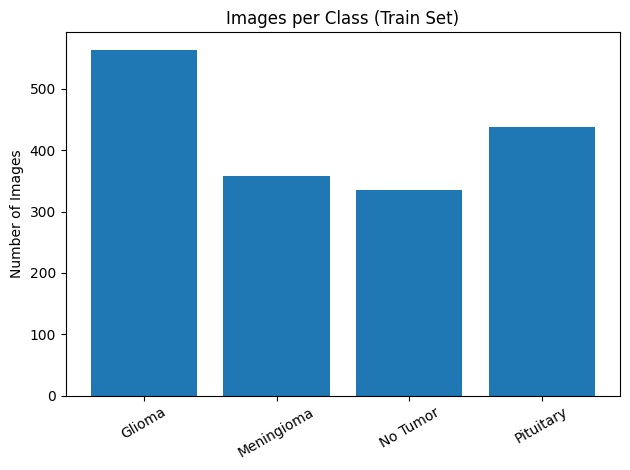

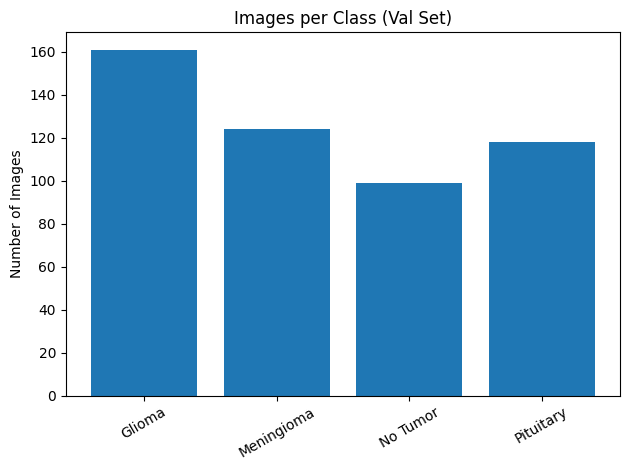

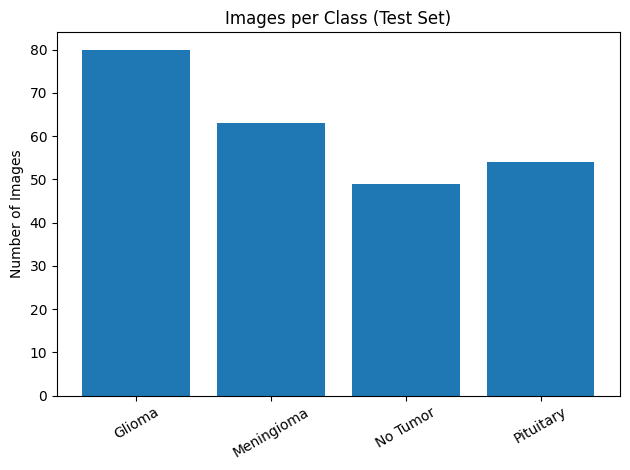

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# ===== Dataset paths =====
dataset_root = "/content/drive/MyDrive/brain_tumor_det/multiclass tumor dataset"
splits = ["train", "val", "test"]

# ===== Class names =====
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

def count_images_per_class(split):
    labels_dir = os.path.join(dataset_root, f"labels/{split}")
    image_counts = Counter()

    for file in os.listdir(labels_dir):
        if file.endswith(".txt"):
            classes_in_image = set()
            with open(os.path.join(labels_dir, file), "r") as f:
                for line in f:
                    class_id = int(line.split()[0])
                    classes_in_image.add(class_id)

            for c in classes_in_image:
                image_counts[c] += 1

    return image_counts

# ===== Plot for each split =====
for split in splits:
    counts = count_images_per_class(split)
    values = [counts[i] for i in range(len(class_names))]

    plt.figure()
    plt.bar(class_names, values)
    plt.title(f"Images per Class ({split.capitalize()} Set)")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
